Mandarin Tone Recognition Part 2
===========
This notebook is a continuation of Mandarin Tone Recognition Part 1

A description of mandarin tones is available here: https://en.wikipedia.org/wiki/Standard_Chinese_phonology#Tones

In part 1, we manually extracted tone lines from the spectrograms of mandarin tone recordings. Features were extracted from these lines, and these features were used to train a random forrest classifier. The resulting accuracy of approximately 75% was insufficient for practical applications. 

In this notebook, the method is altered in two ways: 1) In part 1, we used recordings of single character words only; part 2 uses words of any length. 2) Rather than the manual feature extraction used in part 1, this part uses the raw spectograms as the input for a convolutional neural network.

## 1. Dataset Expansion

In this section, we expand the wiktionary-based pronunciation dataset by including words with variable character length. 

In [1]:
import requests
import itertools
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wiktionaryparser import WiktionaryParser
from pydub import AudioSegment
from pydub import silence
from scipy import signal
from scipy.io import wavfile
from scipy.stats import mode
from tqdm import tqdm_notebook
%matplotlib inline

We use the vocabularly lists for the HSK and TOCFL mandarin examinations to build the dataset. Overlapping entries are be removed.

HSK: 

TOCFL: https://www.sc-top.org.tw/chinese/download.php

In [2]:
files = ['hsk1.txt', 
         'hsk2.txt', 
         'hsk3.txt', 
         'hsk4.txt', 
         'hsk5.txt', 
         'hsk6.txt', 
         'tocflA.txt', 
         'tocflB.txt', 
         'tocflC.txt']
lines = []
for text_file in files:
    with open(text_file, 'r', encoding='utf-8') as file:
        lines += file.readlines()

words = []
for line in lines:
    words.append(re.findall(r'[\u4e00-\u9fff]+', line)[0])

words = list(set(words))
print("{:d} unique mandarin words extracted from the HSK and TOCFL vocab lists".format(len(words)))

8420 unique mandarin words extracted from the HSK and TOCFL vocab lists


The following functions were adapted slightly from those used in part 1 to enable multi-character words. 

The function get_tones returns a list of the tone numbers for the supplied pinyin and hanzi. Some tone patterns result in changes to the pronunciation (e.g., two third tones are pronounced as a second tone followed by a third tone). The function tone_adjustments handles these changes for the majority of cases.

In [13]:
from itertools import groupby, cycle 
  
def group_sequence(l): 
    """
    A helper function for tone adjustment
    Takes a list of integers as its argument
    Returns a list of tuples containing subsequences of l that increase by 1 for each index 
    e.g., [1, 2, 3, 1, 2, 2, 1, 1] returns [(1, 2, 3), (1, 2)]
    """
    temp_list = cycle(l) 
    next(temp_list) 
    groups = groupby(l, key = lambda j: j + 1 == next(temp_list)) 
    for k, v in groups: 
        if k: 
            yield tuple(v) + (next((next(groups)[1])), ) 

def tone_adjustment(tones, hanzi):
    """
    Adjusts a list of tones according to the rules for mandarin tone adjustment and return the corrected list of tones
    (e.g., [3, 3] --> [2, 3])
    """
    three_indexes = [i for i, v in enumerate(tones) if v ==3]
    if len(three_indexes) > 0:
        #Find the indexes of adjacent groups of third tones.
        three_chains = list(group_sequence(three_indexes))
        for three_chain in three_chains:
            tones[min(three_chain):max(three_chain) + 1] = [2]*(max(three_chain) - min(three_chain)) + [3]
    if "不" in hanzi and hanzi[-1] != "不":
        if tones[hanzi.index("不") + 1] == 4:
            tones[hanzi.index("不")] = 2
    if "一" in hanzi and hanzi[-1] != "一":
        following_char = hanzi[hanzi.index("一")+1]
        #There are more exceptions to the tone change rules for 一;
        #they are rather more complex and appear unlikely to affect
        #the multi-character words in this project. See following:
        #https://resources.allsetlearning.com/chinese/pronunciation/Tone_change_rules
        if following_char not in ["一", "二", "三", "四", "五", "六", "七", "八", "九"]:
            if tones[hanzi.index("一")+1] == 4:
                tones[hanzi.index("一")] = 2
            else:
                tones[hanzi.index("一")] = 4
    return tones

In [4]:
def get_tones(pinyin, hanzi):
    """
    Returns a list of integers representing the tones for a pinyin word
    """
    num_chars = len(hanzi)
    tones = []
    found_tones = re.findall("[āēīōūǖĀĒĪŌŪǕáéíóúǘÁÉÍÓÚǗǎěǐǒǔǚǍĚǏǑǓǙàèìòùǜÀÈÌÒÙǛ]", pinyin)
    if len(found_tones) == num_chars:
        for sylable in found_tones:
            if re.search("[āēīōūǖĀĒĪŌŪǕ]", sylable):
                tones.append(1)
            elif re.search("[áéíóúǘÁÉÍÓÚǗ]", sylable):
                tones.append(2)
            elif re.search("[ǎěǐǒǔǚǍĚǏǑǓǙ]", sylable):
                tones.append(3)
            elif re.search("[àèìòùǜÀÈÌÒÙǛ]", sylable):
                tones.append(4)
    elif len(found_tones) < num_chars:
        for sylable in found_tones:
            if re.search("[āēīōūǖĀĒĪŌŪǕ]", sylable):
                tones.append(1)
            elif re.search("[áéíóúǘÁÉÍÓÚǗ]", sylable):
                tones.append(2)
            elif re.search("[ǎěǐǒǔǚǍĚǏǑǓǙ]", sylable):
                tones.append(3)
            elif re.search("[àèìòùǜÀÈÌÒÙǛ]", sylable):
                tones.append(4)
        for i in range(num_chars - len(found_tones)):
            tones.append(5)
            
    return tone_adjustment(tones, hanzi)

In [5]:
def get_pronuncitation(character, verbose=False):
    """
    Returns the standard pronunciation tone for the provided character
    If no audio files are available for the character return False
    Also saves the related audio file as ...\word.ogg
    """
    parser = WiktionaryParser()
    try:
        word = parser.fetch(character, 'chinese')
    except AttributeError as error:
        if verbose:
            print("Attribute error for ", character, error)
        return False
    except KeyError as error:
        if verbose:
            print("Key error for ", character, error)
        return False
    if len(word) > 0:
        if len(word[0]['pronunciations']['audio']) > 0:
            if verbose:
                print(word[0]['pronunciations']['text'][0])
                print("tones: ", get_tones(word[0]['pronunciations']['text'][0].split(":")[1].split()[0], character))
            tones = get_tones(word[0]['pronunciations']['text'][0].split(":")[1].split()[0], character)
            url = 'https:' + word[0]['pronunciations']['audio'][0]
            r = requests.get(url, allow_redirects=True)
            with open(r'word.ogg', 'wb') as file:
                file.write(r.content)
            return tones
        else:
            if verbose:
                print("No audio file available for this hanzi")
            return False
    else:
        if verbose:
            print("No audio file available for this hanzi")
        return False

In [6]:
def trim_silence(data):
    """
    Removes leading and trailing silences from the signal
    Returns the signal with these silences removed.
    """
    non_silent = [np.mean(np.abs(data[i:i+800])) for i in range(len(data)-799)]
    non_silent = (non_silent > max(data)*0.02).tolist()
    start = non_silent.index(True)-int(len(data)*0.005)
    end = len(non_silent) - non_silent[::-1].index(True)+int(len(data)*0.005)
    return data[start:end]

Next, we loop over all the words in the list of unique HSK and TOCFL vocabulary to build the dataset. At each stage an entry is added to the dataframe df if the pronunciation is available. 

Since many of the words are composed of multiple characters, we must find a way to separate the sounds. Attempting to split on silence was unsuccessful, because distinguishable silence between characters is often not present. Therefore, we divide the audio data into equal chunks according to the number of characters expected. This imperfect approach is likely to lead to some undesired overlap (or leakage) between adjacent tone spectrograms. Consider improvements to this approach in future.

In [14]:
df = pd.DataFrame({"hanzi": [], 
                   "tone": [], 
                   "Sxx": []})

for word in tqdm_notebook(words):
    num_chars = len(word)
    tones = get_pronuncitation(word, verbose=False)
    if tones:
        try:
            sound = AudioSegment.from_ogg(r'word.ogg')
        except Exception as error:
            pass
        sound.export(r'word.wav', format="wav")
        #Open the wav file
        fs, data = wavfile.read(r'word.wav')
        if len(data.shape) > 1:
            data = data.T[0]
        #Trim leading and trailing silences
        trimmed_data = trim_silence(data)
        if len(trimmed_data) > 100:
            for i in range(num_chars):
                #Split the data into character chunks
                chunk = trimmed_data[i*int(len(trimmed_data)/num_chars):(i+1)*int(len(trimmed_data)/num_chars)]
                #Obtain spectograms
                f, t, Sxx = signal.spectrogram(chunk, fs, nperseg=1024, nfft=1024*4)
                #Trim the frequency domain
                bound = len([freq for freq in f if freq < 1000])
                Sxx = Sxx[:bound]
                df = df.append(pd.DataFrame({"hanzi": [word], 
                                             "tone": [tones[i]], 
                                             "Sxx": [Sxx]}), ignore_index=True)

The resulting spectograms are of different sizes; we standardize them by adding zeros to create equally sized arrays.

In [16]:
max_frequency = max([f for f, t in list(set(df.Sxx.apply(lambda x: x.shape).tolist()))])
max_time = max([t for f, t in list(set(df.Sxx.apply(lambda x: x.shape).tolist()))])

def pad_frequency(x):
    if x.shape[0] < max_frequency:
        return np.concatenate((x, np.zeros((max_frequency - x.shape[0], x.shape[1]))), axis=0)
    else:
        return x
      
def pad_time(x):
    if x.shape[1] < max_time:
        return np.concatenate((x, np.zeros((x.shape[0], max_time-x.shape[1]))), axis=1)
    else:
        return x

df.Sxx = df.Sxx.apply(lambda x: pad_frequency(pad_time(x)))

## 2. Classifier Training

In this section we train a convolutional neural network (CNN) to classify the spectrograms into one of the 5 tones. CNNs have been successfully applied to the classification of handwritten digits using the MNIST dataset. Initially, we use the model recommended by keras for hand-written digit classification https://keras.io/examples/mnist_cnn/

In [17]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import regularizers
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [18]:
batch_size = 128
num_classes = 5
epochs = 12

img_rows, img_cols = max_frequency, max_time
input_shape = (img_rows, img_cols, 1)

In [19]:
X = df.Sxx.values
X = np.array([x.tolist() for x in X.flatten()]).reshape(X.shape[0], img_rows, img_cols)
y = df.tone.values

#Normalize each image by dividing by the maximum value for that image.
for i in range(X.shape[0]):
    X[i] = X[i] / np.max(X[i])

#Instead of tones 1-5, the classifier will predict 0-4. 
#Subtract 1 from all samples; 1 will be added to the 
#prediction result to yield the appropriate tone designation
y = y - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

In [34]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 92, 38, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 18, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 45, 18, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 51840)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               6635648   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
__________

In [35]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=12,
          verbose=2,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1475 samples, validate on 369 samples
Epoch 1/12
 - 16s - loss: 1.1749 - acc: 0.5641 - val_loss: 0.7708 - val_acc: 0.7615
Epoch 2/12
 - 14s - loss: 0.7399 - acc: 0.7620 - val_loss: 0.6348 - val_acc: 0.8130
Epoch 3/12
 - 14s - loss: 0.5763 - acc: 0.8217 - val_loss: 0.5117 - val_acc: 0.8455
Epoch 4/12
 - 14s - loss: 0.4284 - acc: 0.8678 - val_loss: 0.4755 - val_acc: 0.8645
Epoch 5/12
 - 14s - loss: 0.3478 - acc: 0.8902 - val_loss: 0.4292 - val_acc: 0.8726
Epoch 6/12
 - 15s - loss: 0.3064 - acc: 0.9044 - val_loss: 0.4173 - val_acc: 0.8889
Epoch 7/12
 - 14s - loss: 0.2491 - acc: 0.9295 - val_loss: 0.4194 - val_acc: 0.8889
Epoch 8/12
 - 14s - loss: 0.2064 - acc: 0.9376 - val_loss: 0.4488 - val_acc: 0.8862
Epoch 9/12
 - 14s - loss: 0.1722 - acc: 0.9525 - val_loss: 0.4459 - val_acc: 0.8916
Epoch 10/12
 - 14s - loss: 0.1500 - acc: 0.9553 - val_loss: 0.4703 - val_acc: 0.9024
Epoch 11/12
 - 14s - loss: 0.1376 - acc: 0.9586 - val_loss: 0.5085 - val_acc: 0.8916
Epoch 12/12
 - 15s - loss: 

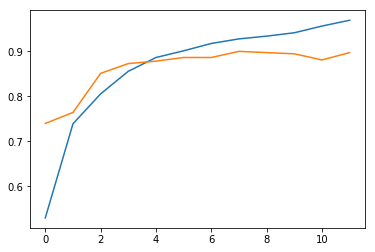

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

Classification using a CNN and the addition of multi-character words yields a substantial improvement in prediction accuracy. 

## 3. User Input Classification

Similarly to part 1, we would now like to take a recorded input from the user and classify the tones. Given that multi-character words were used for training, we should also be able to take a multi-character word input from the user. After triming the leading and trailing silences, the resulting data will be divided into equal chunks according to the number of characters expected. 

In some cases, the time dimension of the user input spectrogram may exceed that provided to the classifier during training. We can sample from the user input to reduce the time dimension, however this is not ideal and may lead to an improper classification. Consider adopting a recurrent neural network architecture to process sequence data of unknown length.

In [23]:
import sounddevice as sd
from scipy.io.wavfile import write

In [24]:
def predict_tone(num_chars):
    """
    Record an audio file from user; return the predicted tones for each character
    """
    fs = 44000
    seconds = 3 
    print("Recording: Start")
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
    sd.wait()
    print("Recording: Stop")
    write(r'rec.wav', fs, myrecording)
    fs, data = wavfile.read(r'rec.wav')
    if len(data.shape) > 1:
        data = data.T[0]
    #Trim leading and trailing silences
    non_silent = [np.mean(np.abs(data[i:i+800])) for i in range(len(data)-799)]
    non_silent = (non_silent > max(data)*0.02).tolist()
    start = non_silent.index(True)-int(len(data)*0.005)
    end = len(non_silent) - non_silent[::-1].index(True)+int(len(data)*0.005)
    trimmed_data = data[start:end]
    
    predictions = []
    
    for i in range(num_chars):
        chunk = trimmed_data[i*int(len(trimmed_data)/num_chars):(i+1)*int(len(trimmed_data)/num_chars)]
        #Obtain spectograms
        f, t, Sxx = signal.spectrogram(chunk, fs, nperseg=1024, nfft=1024*4)
        #Trim the frequency domain
        bound = len([freq for freq in f if freq < 1000])
        Sxx = Sxx[:bound]
        #Pad the time and frequency domains to match the classifier dimensions
        Sxx = pad_frequency(pad_time(Sxx))
        Sxx = Sxx / np.max(Sxx)
        #TO DO: The size of the spectogram recorded from the user exceeds the 
        #size must be reduced somehow to fit the model
        ##
        ##
        ##
        ##
        Sxx = Sxx.reshape(1, img_rows, img_cols, 1)
        predictions.append(model.predict(Sxx))
    return predictions

In [25]:
prediction = predict_tone(num_chars=2)
for i, sylable in enumerate(prediction):
    print("Sylable {:d} prediction: {:d}".format(i, np.argmax(sylable) + 1))
    for j in range(5):
        print("Tone {:d} probability: {:f}%".format(j + 1, sylable[0][j]*100))
    print("...")

Recording: Start
Recording: Stop
Sylable 0 prediction: 1
Tone 1 probability: 99.950278%
Tone 2 probability: 0.025686%
Tone 3 probability: 0.012913%
Tone 4 probability: 0.010186%
Tone 5 probability: 0.000932%
...
Sylable 1 prediction: 2
Tone 1 probability: 0.972835%
Tone 2 probability: 61.734140%
Tone 3 probability: 17.255640%
Tone 4 probability: 16.305369%
Tone 5 probability: 3.732009%
...


## 4. Next Steps

Remaining problems with this approach:

1. Insufficient training data: although the ammount of training data was greatly increased by including multi-character words, more data are likely required to increase the accuracy of the classifier. For example, the MNIST dataset for which our classifier was designed, includes XXX samples for each category.
2. Although the classifier achieved an accuracy of approximately 90% on the test data, testing with native mandarin speakers appears to yield considerably poorer results. This may be due to the lack of diversity in the training data (mostly male voice and Putonghua acccent); increasing the diversity of the data along with increasing the size of the dataset may improve the applicability of the classifier to a practical context.